# Required Library

In [41]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image

# Prepare Dataset

In [42]:
# Paths
DATA_DIR    = r'C:\Users\ASUS ZENBOOK\Desktop\Dataset'
TRAIN_DIR   = os.path.join(DATA_DIR, 'train')
VAL_DIR     = os.path.join(DATA_DIR, 'validation')

# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Automatically detect the number of classes
class_names = os.listdir(TRAIN_DIR)  # Assuming classes are in the train directory
num_classes = len(class_names)

# Print detected classes vertically
print(f"Detected {num_classes} classes:")
for class_name in class_names:
    print(f"- {class_name}")

# Define the preprocess_image function
def preprocess_image(image):
    # Ensure the image is in the correct format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    # Convert numpy array to PIL Image
    image = Image.fromarray(image)
    
    if image.mode == 'P':  # If the image is in palette mode
        image = image.convert('RGBA')
    
    # Convert back to numpy array and ensure it's in float32 format
    return np.array(image).astype(np.float32)

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_image
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    preprocessing_function=preprocess_image
)

# Load datasets
train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Save class indices
with open("class_indices.json", "w") as f:
    json.dump(train_data.class_indices, f)


Detected 31 classes:
- Baked Potato
- Bread
- Burger
- Cheese Cookies
- Crescent Cookies
- Crispy Chicken
- Donut
- Egg
- Fried Chicken
- Fried Fish
- Fried Noodles
- Fried Rice
- Fried Spring Rolls
- Fries
- Gado-Gado
- Hot Dog
- Klepon
- Layer Cake
- Lumpur Cake
- Padang Rice
- Pasta
- Pizza
- Rawon
- Rendang
- Sandwich
- Satay
- Serabi
- Soto
- Sweet Coconut Pancake
- Taco
- Taquito
Found 22929 images belonging to 31 classes.
Found 4996 images belonging to 31 classes.


#  Build & Train Model

In [34]:
# Build model function
def build_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model layers

    # Add custom layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

# Custom callback to log learning rate
class LearningRateLogger(Callback):
    def __init__(self):
        super(LearningRateLogger, self).__init__()
        self.learning_rates = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy()
        self.learning_rates.append(lr)
        logs = logs or {}
        logs['learning_rate'] = lr

# Build model
model = build_model(num_classes=num_classes)

# Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Initialize the logger
lr_logger = LearningRateLogger()

# Callbacks
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Train the model for exactly 10 epochs without early stopping
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,  # Set epochs to 10
    callbacks=[checkpoint, lr_logger]  # Removed early stopping
)

# Save the model
model.save('final_model.h5')

Epoch 1/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 363s 494ms/step - accuracy: 0.0959 - loss: 3.1130 - val_accuracy: 0.1003 - val_loss: 3.2197 - learning_rate: 0.0010
Epoch 2/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 355s 487ms/step - accuracy: 0.1256 - loss: 2.9440 - val_accuracy: 0.1015 - val_loss: 3.3858 - learning_rate: 0.0010
Epoch 3/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 358s 490ms/step - accuracy: 0.1379 - loss: 2.9079 - val_accuracy: 0.1015 - val_loss: 3.5502 - learning_rate: 0.0010
Epoch 4/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 532s 729ms/step - accuracy: 0.1353 - loss: 2.8892 - val_accuracy: 0.0885 - val_loss: 3.4692 - learning_rate: 0.0010
Epoch 5/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 577s 790ms/step - accuracy: 0.1448 - loss: 2.8620 - val_accuracy: 0.0933 - val_loss: 3.5518 - learning_rate: 0.0010
Epoch 6/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 597s 818ms/step - accuracy: 0.1492 - loss: 2.8392 - val_accuracy: 0.0931 - val_loss: 3.5444 - learning_rate: 0.0010
Epoch 7/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 544s 745ms/step - accura

In [43]:
# Build model function
def build_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True  # Unfreeze the base model layers for fine-tuning

    # Fine-tune some layers
    for layer in base_model.layers[:-20]:  # Freeze all but the last 20 layers
        layer.trainable = False

    # Add custom layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

# Compile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Adjusted learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint(
    filepath='best_model2.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop training if validation loss doesn't improve for 5 epochs
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=[checkpoint, early_stopping, lr_logger]  # Added early stopping
)

# Save the model
model.save('final_model2.h5')

Epoch 1/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 1179s 2s/step - accuracy: 0.1286 - loss: 2.9373 - val_accuracy: 0.1049 - val_loss: 3.2789 - learning_rate: 1.0000e-04
Epoch 2/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 502s 701ms/step - accuracy: 0.1383 - loss: 2.9113 - val_accuracy: 0.0993 - val_loss: 3.3529 - learning_rate: 1.0000e-04
Epoch 3/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 473s 660ms/step - accuracy: 0.1439 - loss: 2.9004 - val_accuracy: 0.1007 - val_loss: 3.3595 - learning_rate: 1.0000e-04
Epoch 4/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 491s 684ms/step - accuracy: 0.1427 - loss: 2.9002 - val_accuracy: 0.1017 - val_loss: 3.4223 - learning_rate: 1.0000e-04
Epoch 5/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 602s 841ms/step - accuracy: 0.1395 - loss: 2.8927 - val_accuracy: 0.1039 - val_loss: 3.4743 - learning_rate: 1.0000e-04
Epoch 6/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 662s 923ms/step - accuracy: 0.1442 - loss: 2.8893 - val_accuracy: 0.1073 - val_loss: 3.4678 - learning_rate: 1.0000e-04


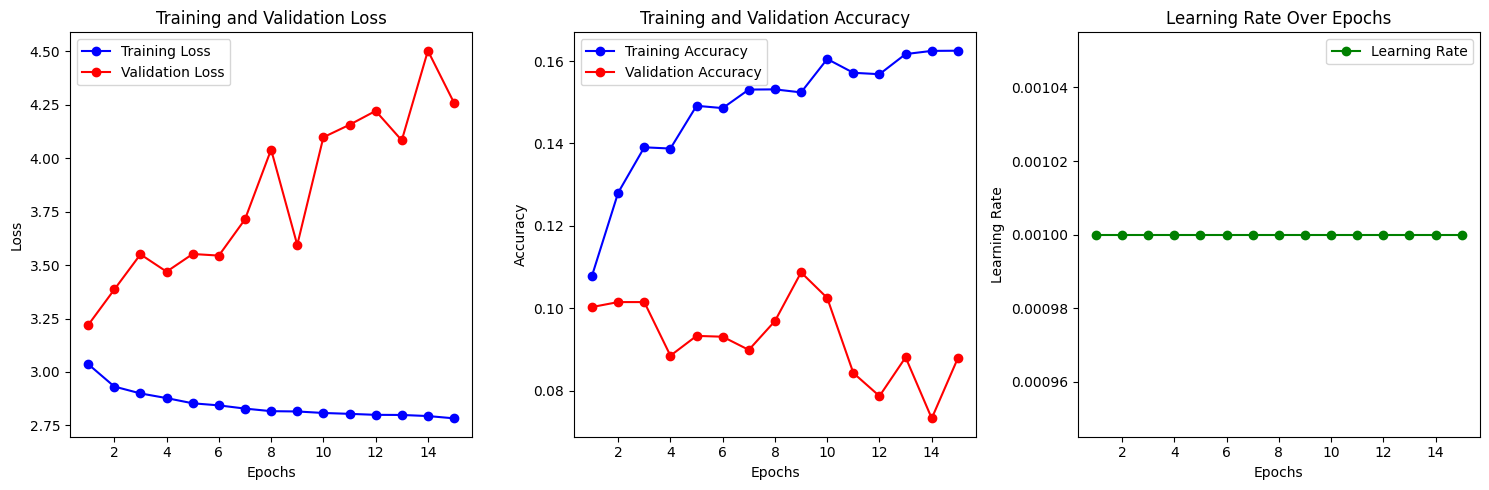

In [35]:
# Plotting
epochs = range(1, len(history.history['loss']) + 1)

# Loss Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Learning Rate Plot
plt.subplot(1, 3, 3)
plt.plot(epochs, lr_logger.learning_rates, 'go-', label='Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

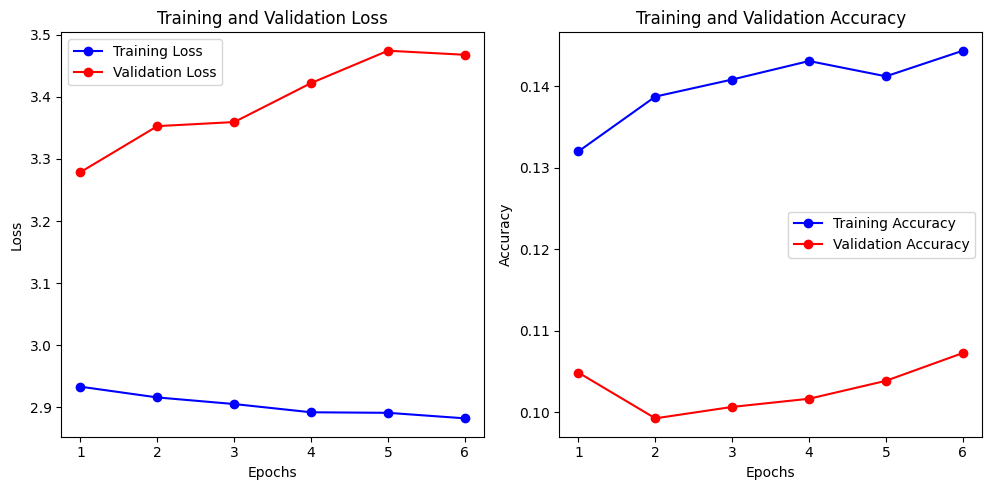

In [47]:
# Plotting
epochs = range(1, len(history.history['loss']) + 1)

# Loss Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate Model

In [39]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = load_model("best_model.keras")  # Use the model you want to evaluate

# Set up the test data generator (make sure you have the test images available)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
   r'C:\Users\ASUS ZENBOOK\Desktop\Dataset\Test',  # Replace with the correct path to your test data
    target_size=(224, 224),  # Image size used for model training
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 3058 images belonging to 31 classes.
96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 258ms/step - accuracy: 0.1429 - loss: 3.3350
Test Accuracy: 11.38%


In [50]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = load_model("best_model2.keras")  # Use the model you want to evaluate

# Set up the test data generator (make sure you have the test images available)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
   r'C:\Users\ASUS ZENBOOK\Desktop\Dataset\Test',  # Replace with the correct path to your test data
    target_size=(224, 224),  # Image size used for model training
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 1763 images belonging to 15 classes.


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 15), output.shape=(None, 31)